## First, run this cell to set up paths and import dependencies

In [1]:
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

if not os.path.exists("./notebooks"):
    %cd ..

from src.data_processing import load_audio, split_into_clips, create_spectrogram, prepare_datasets, list_audio_files, SOAAudioClips, save_mean_std, compute_mean_std_from_images
from src.dataset_analysis import plot_spectrogram, duration_statistics
from src.config import VALID_ACCESS_LABELS, TRAIN_DIR, TEST_DIR, VAL_DIR, DATA_DIR, DATASET_DIR

# Ensure the output directory structure exists
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)


/Users/boryskurdek/Studia/ml/iml


## 1. Load all .wav files in the provided directory and preview some

In [2]:
wav_files = list_audio_files(DATA_DIR)
print(f"Found {len(wav_files)} .wav files in directory '{DATA_DIR}'")

Found 100 .wav files in directory './data'


## 2. Statistics about authorized/unauthorized speakers

In [3]:
authorized_speakers_files = []
unauthorized_speakers_files = []

for file in wav_files:
    speaker_id = os.path.split(file)[-1].split('_')[0]
    if speaker_id in VALID_ACCESS_LABELS:
        authorized_speakers_files.append(file)
    else:
        unauthorized_speakers_files.append(file)

print("Authorized speakers recordings:")
soa_authorized = SOAAudioClips(authorized_speakers_files)
print(duration_statistics(soa_authorized.clips))

print("\nUnauthorized speakers recordings:")
soa_unauthorized = SOAAudioClips(unauthorized_speakers_files)
print(duration_statistics(soa_unauthorized.clips))

Authorized speakers recordings:
Statistics:
        Total files: 30,
        Total duration: 4978.07 sec,
        Average duration: 165.94 sec, 
        Duration range: 132.03 - 198.58 sec
        

Unauthorized speakers recordings:
Statistics:
        Total files: 70,
        Total duration: 11118.22 sec,
        Average duration: 158.83 sec, 
        Duration range: 116.16 - 224.20 sec
        


## 3. Split files into train, validation, and test sets

In [4]:
train_files, val_files, test_files = prepare_datasets(DATA_DIR)
print(f"Training files: {len(train_files)} | Validation files: {len(val_files)} | Test files: {len(test_files)}")

def save_spectrogram(spectrogram, output_path):
    plt.imsave(output_path, spectrogram, cmap='gray')


Training files: 64 | Validation files: 16 | Test files: 20


## 4. Calculate and display statistics about raw dataset

In [5]:
soa_train_full_clips = SOAAudioClips(train_files)
soa_test_full_clips = SOAAudioClips(test_files)
soa_val_full_clips = SOAAudioClips(val_files)

print("\nDataset Statistics:")
print("Training set:")
print(duration_statistics(soa_train_full_clips.clips))

print("Validation set:")
print(duration_statistics(soa_test_full_clips.clips))

print("Test set:")
print(duration_statistics(soa_val_full_clips.clips))


Dataset Statistics:
Training set:
Statistics:
        Total files: 64,
        Total duration: 10235.55 sec,
        Average duration: 159.93 sec, 
        Duration range: 116.16 - 199.72 sec
        
Validation set:
Statistics:
        Total files: 20,
        Total duration: 3243.17 sec,
        Average duration: 162.16 sec, 
        Duration range: 120.83 - 192.71 sec
        
Test set:
Statistics:
        Total files: 16,
        Total duration: 2617.57 sec,
        Average duration: 163.60 sec, 
        Duration range: 132.03 - 224.20 sec
        


## 5. Process each dataset split by converting 3-second clips into spectrograms

In [6]:
def process_split(soa_full_clips, output_subdir):
    all_splitted_clips = []
    for file_path, full_clip in tqdm(soa_full_clips):
        clips = split_into_clips(full_clip)
        all_splitted_clips.extend(clips)
        for i, clip in enumerate(clips):
            spectrogram = create_spectrogram(clip)
            output_path = os.path.join(output_subdir, f"{os.path.basename(file_path).split('.')[0]}_{i}_clip.png")
            save_spectrogram(spectrogram, output_path)
    print(duration_statistics(all_splitted_clips))

print("Preprocessed Train Dataset:")
process_split(soa_train_full_clips, TRAIN_DIR)

print("\nPreprocessed Validation Dataset:")
process_split(soa_val_full_clips, VAL_DIR)

print("\nPreprocessed Test Dataset:")
process_split(soa_test_full_clips, TEST_DIR)


Preprocessed Train Dataset:


100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


Statistics:
        Total files: 3383,
        Total duration: 10149.00 sec,
        Average duration: 3.00 sec, 
        Duration range: 3.00 - 3.00 sec
        

Preprocessed Validation Dataset:


100%|██████████| 16/16 [00:03<00:00,  4.00it/s]


Statistics:
        Total files: 865,
        Total duration: 2595.00 sec,
        Average duration: 3.00 sec, 
        Duration range: 3.00 - 3.00 sec
        

Preprocessed Test Dataset:


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]

Statistics:
        Total files: 1071,
        Total duration: 3213.00 sec,
        Average duration: 3.00 sec, 
        Duration range: 3.00 - 3.00 sec
        


## 6. Mean and Standard deviation of training dataset

In [7]:
mean, std = compute_mean_std_from_images(TRAIN_DIR)
print(f"Mean: {mean}, Standard deviation: {std}")
save_mean_std(mean, std, f"{DATASET_DIR}/scaling_params.json")

Mean: 0.3074067533016205, Standard deviation: 0.23026961088180542


## 7. Visualize some spectrogram examples

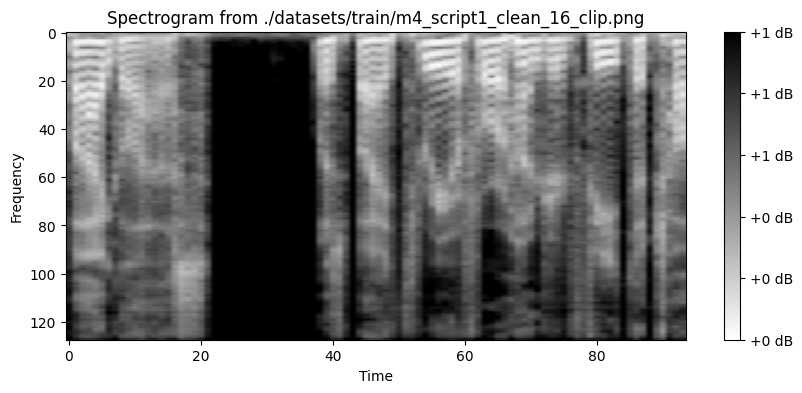

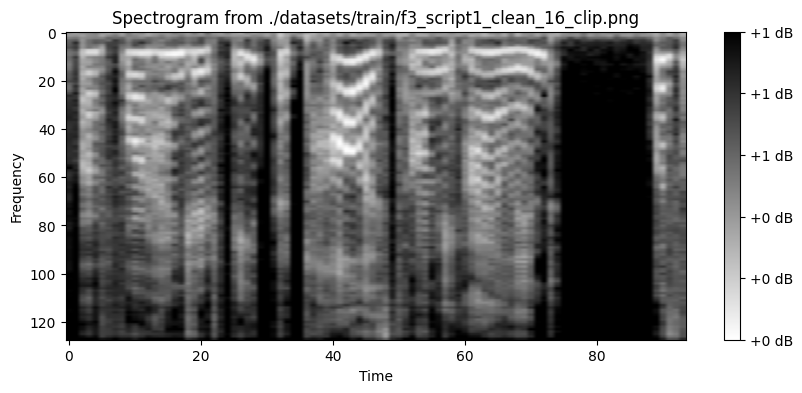

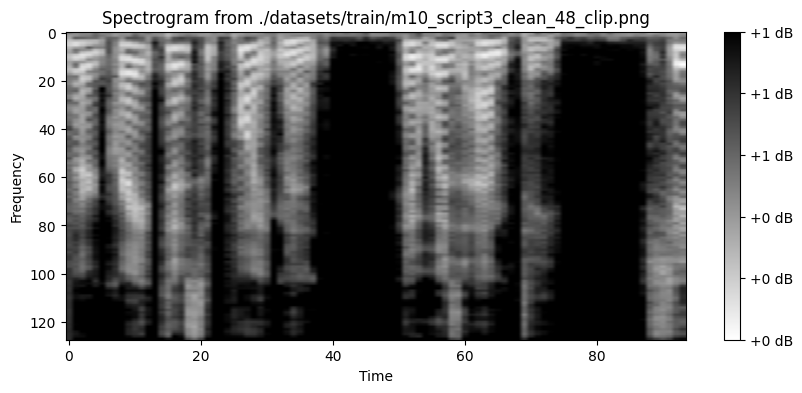

In [8]:
sample_spectrogram_paths = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)[:3]]
for path in sample_spectrogram_paths:
    spectrogram = plt.imread(path)
    plot_spectrogram(spectrogram, title=f"Spectrogram from {path}")